#### Business Analytics FHDW 2025
# Time Series
## Grundlegende Handhabung und Aufbereitung

Wir schauen uns den bekannten Datensatz *Amtrak.csv* mit Fahrgastzahlen (*ridership*) aus den Jahren 1991 bis 2004 an.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from dmba import regressionSummary

amtrak_df = pd.read_csv('Daten/Amtrak.csv')
amtrak_df

,Month,Ridership
0,01/01/1991,1708.917
1,01/02/1991,1620.586
2,01/03/1991,1972.715
3,01/04/1991,1811.665
4,01/05/1991,1974.964
...,...,...
154,01/11/2003,2076.054
155,01/12/2003,2140.677
156,01/01/2004,1831.508
157,01/02/2004,1838.006


*pandas* nutzt bei der Verarbeitung von Zeitwerten und -reihen eigene Strukturen (eine gute Übersicht z. B. hier: https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html). Im eingelesenen `DataFrame` sind die Datumswerte einfach Zeichenketten:

In [2]:
print(amtrak_df.Month[0])
type(amtrak_df.Month[0])

01/01/1991


str

Zeitreihen in *pandas* werden indiziert durch `Timestamp`s. Also bauen wir uns aus der Spalte *Month* aus den dort gespeicherten Zeichenketten mit `to_datetime` eine Reihe solcher Zeitwerte. Die Funktion könnte das Format auch selbst erkennen. Indem wir es explizit im Parameter `format` angeben, arbeitet sie aber effizienter (wichtig gerade bei sehr großen Datensätzen).

In [3]:
ridership_dates = pd.to_datetime(amtrak_df.Month, format='%d/%m/%Y')
ridership_dates

0     1991-01-01
1     1991-02-01
2     1991-03-01
3     1991-04-01
4     1991-05-01
         ...    
154   2003-11-01
155   2003-12-01
156   2004-01-01
157   2004-02-01
158   2004-03-01
Name: Month, Length: 159, dtype: datetime64[ns]

Die Zeitreihe der Fahrgastzahlen legen wir gesondert als `Series` an. *pandas*'s `Series` ist ein eindimensionales Array, das aber viel Flexibilität in der Nutzung eines Index bietet. Die Werte kommen aus der Spalte *Ridership* des `DataFrame` oben, als Index benutzen wir die gerade erzeugte Datumsreihe. Wir geben außerdem einen Namen an, damit die Werte der Zeitreihe in weiteren Berechnungen referenzierbar sind.

Unsere Fahrgast-`Series`benötigt einen `DatetimeIndex`, um die zeitbezogenen Operationen von *pandas* auf den Daten zu ermöglichen. Die Frequenz lassen wir dabei ermitteln (`inferred_freq`), in diesem Fall ist das *MS = monthly start* bzw. *MonthBegin*.

In [4]:
ridership_ts = pd.Series(amtrak_df.Ridership.values, index=ridership_dates, name='Ridership')
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, ridership_ts.index.inferred_freq)
ridership_ts.index.freq

<MonthBegin>

## Erste einfache Analysen und Prognosen

Die Visualisierung ist bei Zeitreihen ein nahe liegender erster Ansatz, um einen Eindruck von ihren Komponenten zu bekommen. Nach den Vorbereitungen oben können wir unsere Zeitreihe der Fahrgastzahlen ausgeben und plotten.

Month
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Freq: MS, Name: Ridership, Length: 159, dtype: float64


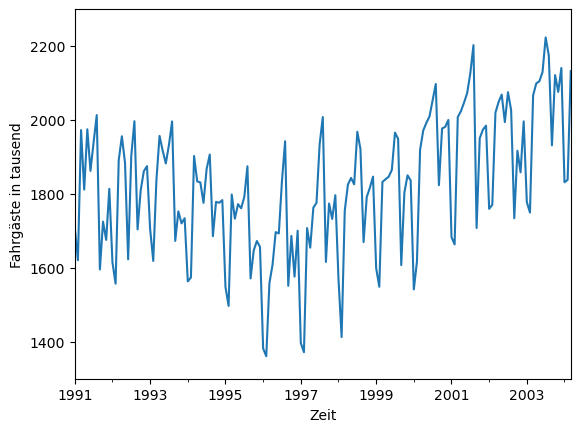

In [5]:
print(ridership_ts)

ax = ridership_ts.plot()
ax.set_xlabel('Zeit')
ax.set_ylabel('Fahrgäste in tausend')
ax.set_ylim(1300, 2300)
plt.show()

Auf diese Weise erkennen wir bereits tendenziell Trends und Saisonalitäten. Trends können wir deutlicher hervorheben, indem wir durch Aggregation oder Durchschnitte mittels `resample` (Zielkonversion *Y*ear) und `agg` die Saisonalitäten unterdrücken. Die Saisonalitäten und sonstige Verlaufsmuster können wir durch "reinzoomen" besser sehen, oder, indem wir Perioden übereinander legen.

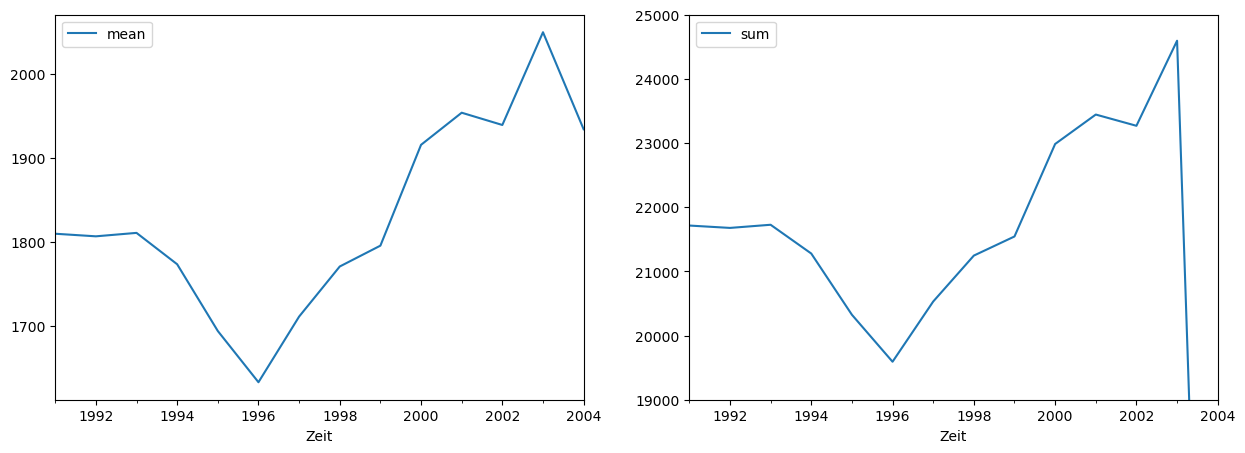

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ridership_ts.resample('YE').agg(["mean"]).plot(xlabel="Zeit", ax=axes[0])
ridership_ts.resample('YE').agg(["sum"]).plot(xlabel="Zeit", ylim=(19000, 25000), ax=axes[1])
plt.show()

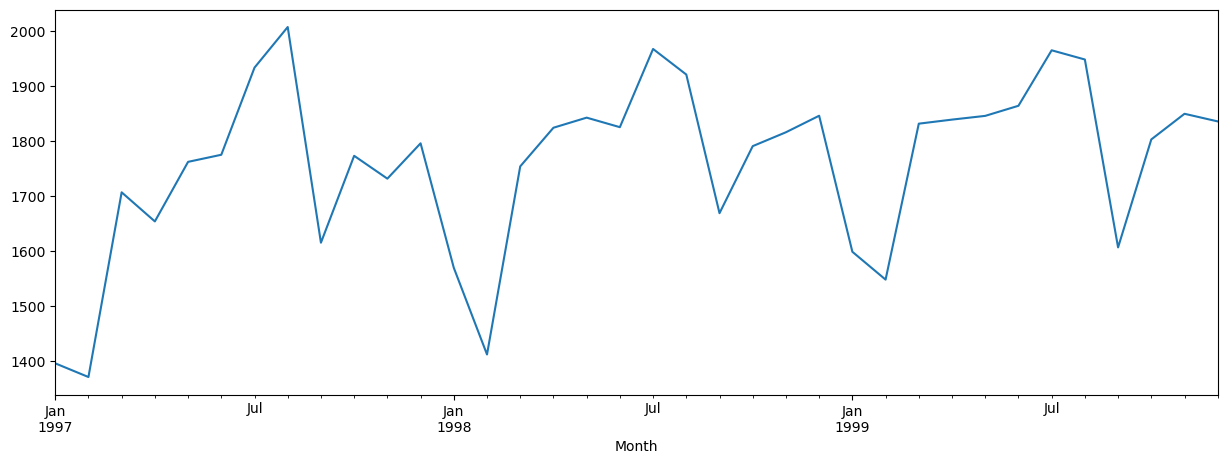

In [7]:
ridership_ts['1997':'1999'].plot(figsize=(15,5))
plt.show()

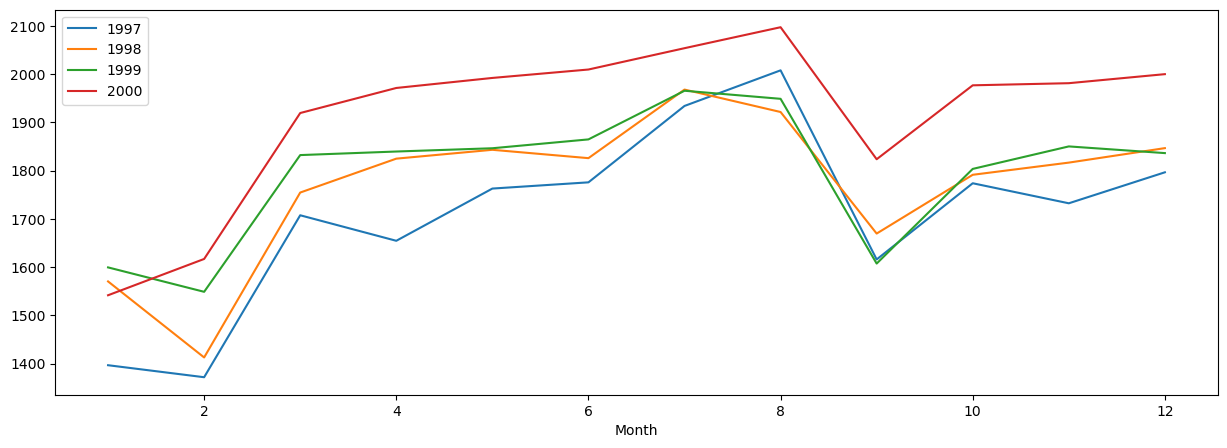

In [8]:
ax = plt.subplot()
for y in ['1997', '1998', '1999', '2000']:
    ridership_period = ridership_ts[y]
    ridership_period.index = ridership_period.index.month
    ridership_period.plot(figsize=(15,5), label=y)
ax.legend()
plt.show()

Es gibt naive Prognosen, die uns aber gleichzeitig als Benchmark bzw. Vergleich für die Zuverlässigkeit fortgeschrittener Methoden dienen können. Sie nutzen einfach frühere Werte. Im simpelsten Fall ist das der letzte bekannte Wert der Reihe. Dieser wird als Prognose fortgeschrieben. 

Wollen wir zusätzlich Saisonalität berücksichtigen, nutzen wir für die Prognose die letzte bekannte Saison. Dann ist z. B. die Vorhersage für März des nächsten Jahres der Wert aus dem letzten vorliegenden März, März des übernächsten Jahres ebenso usw.

Diese beiden naiven Vorhersagen generieren wir uns für das Amtrak-Beispiel.

In [9]:
n_valid = 36 # Monate für die Validierung
n_train = len(ridership_ts) - n_valid

train_ts = ridership_ts[:n_train]
valid_ts = ridership_ts[n_train:]

# Aus dem letzten bekannten Wert der Trainingsdaten wird eine
# Folge für jeden Timestamp/Index der Validierungsdaten erzeugt:
naive_prediction = pd.Series(train_ts.iloc[-1], index=valid_ts.index)

# Um die vergangene Saison zu erfassen, gehen wir zwölf Monate zurück
# und übernehmen die Trainingsdaten von dort bis zu ihrem Ende:
last_season = train_ts[-12:]
# Dann kopieren wir die letzte Saison mit concat drei mal hintereinander,
# und speichern das Ergebnis mit dem Index der Validierungsdaten:
seasonal_prediction = pd.Series(pd.concat([last_season]*3).values, index=valid_ts.index)

print("Einfache naive Prognose ------------------")
print(naive_prediction)
print("Saisonale naive Prognose ------------------")
print(seasonal_prediction)

Einfache naive Prognose ------------------
Month
2001-04-01    2007.928
2001-05-01    2007.928
2001-06-01    2007.928
2001-07-01    2007.928
2001-08-01    2007.928
2001-09-01    2007.928
2001-10-01    2007.928
2001-11-01    2007.928
2001-12-01    2007.928
2002-01-01    2007.928
2002-02-01    2007.928
2002-03-01    2007.928
2002-04-01    2007.928
2002-05-01    2007.928
2002-06-01    2007.928
2002-07-01    2007.928
2002-08-01    2007.928
2002-09-01    2007.928
2002-10-01    2007.928
2002-11-01    2007.928
2002-12-01    2007.928
2003-01-01    2007.928
2003-02-01    2007.928
2003-03-01    2007.928
2003-04-01    2007.928
2003-05-01    2007.928
2003-06-01    2007.928
2003-07-01    2007.928
2003-08-01    2007.928
2003-09-01    2007.928
2003-10-01    2007.928
2003-11-01    2007.928
2003-12-01    2007.928
2004-01-01    2007.928
2004-02-01    2007.928
2004-03-01    2007.928
Freq: MS, dtype: float64
Saisonale naive Prognose ------------------
Month
2001-04-01    1971.493
2001-05-01    1992.301
20

Trainings-, Validierungs- und Prognosedaten können wir dann visualisieren.

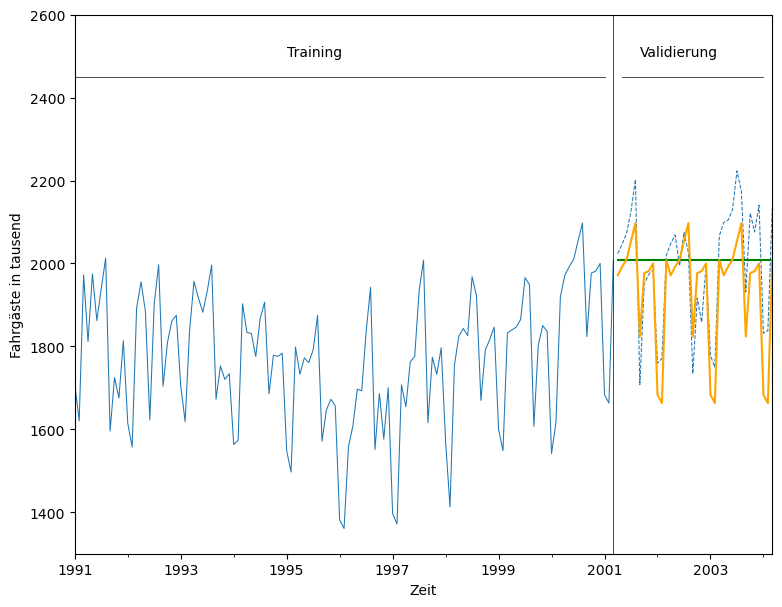

In [10]:
ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
ax.set_xlim('1990', '2006-6')
ax.set_ylim(1300, 2600)
ax.set_ylabel('Fahrgäste in tausend')

naive_prediction.plot(ax=ax, color='green')
seasonal_prediction.plot(ax=ax, color='orange')

one_month = pd.Timedelta('31 days')
xtrain = (min(train_ts.index), max(train_ts.index)-one_month)
xvalid = (min(valid_ts.index)+one_month, max(valid_ts.index)-one_month)
xtv = xtrain[1]+0.5*(xvalid[0]-xtrain[1])
xvf = xvalid[1]+0.5*((max(valid_ts.index)+one_month)-xvalid[1])

ax.add_line(plt.Line2D(xtrain, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xvalid, (2450, 2450), color='black', linewidth=0.5))
ax.text('1995', 2500, 'Training')
ax.text('2001-9', 2500, 'Validierung')
#ax.text('2004-7', 2500, 'Zukunft')
ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)
ax.set_xlabel('Zeit')
plt.show()

Zur Beurteilung der Performance und auch für spätere Vergleiche (Benchmarking) können wir uns die Kennzahlen generieren, die wir schon für die Regression genutzt haben. Es ist ja auch hier eine Art Anpassung.

In [11]:
regressionSummary(valid_ts, naive_prediction)
regressionSummary(valid_ts, seasonal_prediction)


Regression statistics

                      Mean Error (ME) : -14.7177
       Root Mean Squared Error (RMSE) : 142.7551
            Mean Absolute Error (MAE) : 115.9234
          Mean Percentage Error (MPE) : -1.2750
Mean Absolute Percentage Error (MAPE) : 6.0214

Regression statistics

                      Mean Error (ME) : 54.7296
       Root Mean Squared Error (RMSE) : 95.6243
            Mean Absolute Error (MAE) : 84.0941
          Mean Percentage Error (MPE) : 2.6528
Mean Absolute Percentage Error (MAPE) : 4.2477


## Aufgabe

Lesen Sie aus der Datei *monthly-shampoo-sales.csv* die monatlichen Absatzzahlen eines Shampoos über drei Jahre.

- Speichern Sie die Daten als Zeitreihe in einer `Series`.
- Stellen Sie die Daten dar.
- Welche Komponenten (Level, Trend, Saisonalität, Rauschen) sind hier erkennbar?